# Test the CRGAN

This demo is based on UCSDped2 dataset, please set `config/env.py` as:
```
benchmark = 'UCSDped2'
base_dir = '~/Data/anomaly-detection-datasets'
```
Of course if you want to test on other dataset, you can also set `benchmark` as `Avenue` etc.

In [1]:
import torch
import pdb

device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")

In [2]:
from util.data import PreprocessFolder
from config import dataset_config

test_dataset = PreprocessFolder(dataset_config["test_dataset"])

In [3]:
def collate(batch):
    inputs = torch.stack([item[0] for item in batch], dim=0)
    bboxes = [item[1] for item in batch]
    labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
    return inputs, bboxes, labels

In [4]:
from torch.utils.data import DataLoader

test_data = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate)

In [5]:
bbox_size = (64, 64)

def bboxes2masks(inputs, bboxes):
    masks = torch.zeros(inputs.shape[0], 5, inputs.shape[2], inputs.shape[3]).to(inputs.device)
    for b, bbox in enumerate(bboxes):
        for points in bbox:
            x_0, y_0, x_1, y_1 = points
            width = x_1 - x_0
            height = y_1 - y_0
            i = int(round(y_0.item()))
            j = int(round(x_0.item()))
            h = int(round(height.item()))
            w = int(round(width.item()))
            masks[b, :3, i:i + h, j:j + w] = 1.0
    return masks


def bboxes2regions(inputs, bboxes):
    return torchvision.ops.roi_align(inputs, bboxes, bbox_size)

In [6]:
from model.crgan import Generator, SDiscriminator, RDiscriminator

g_model = Generator().to(device)
d_model_s = SDiscriminator().to(device)
d_model_r = RDiscriminator().to(device)

In [7]:
from config import benchmark

if benchmark == 'Avenue':
    models = torch.load('parameters/train_avenue_exp.pth')
elif benchmark == 'UCSDped1':
    models = torch.load('parameters/train_ucsd1_exp.pth')
elif benchmark == 'UCSDped2':
    models = torch.load('parameters/train_ucsd2_exp.pth')
elif benchmark == 'ShanghaiTech':
    models = torch.load('parameters/train_shanghaitech_exp.pth')
elif benchmark == 'ShanghaiTech1':
    models = torch.load('parameters/train_shanghaitech1_exp.pth')
elif benchmark == 'UMN':
    models = torch.load('parameters/train_umn_exp.pth')
    
g_model.load_state_dict(models['g_model'])
d_model_s.load_state_dict(models['d_model_s'])
d_model_r.load_state_dict(models['d_model_r'])

<All keys matched successfully>

In [8]:
gamma = 0.5

def forward(inputs, bboxes):
    with torch.set_grad_enabled(False):

        masks = bboxes2masks(inputs, bboxes)
        masked_inputs = inputs * (1 - masks)

        motion_condition = inputs[:, 3:]
        outputs = g_model(masked_inputs)
        outputs_condition = torch.cat([outputs, motion_condition], dim=1)
        prediction_scene = -d_model_s(outputs_condition)

        outputs_condition = outputs_condition

        prediction_regions = torch.zeros_like(prediction_scene)
        for i, bbox in enumerate(bboxes):
            if bbox.shape[0] == 0:
                continue
            output_regions = bboxes2regions(outputs_condition[i].unsqueeze(0), [bbox])
            prediction_regions[i] = (-d_model_r(output_regions)).max()
    
    return prediction_scene * (1 - gamma) + prediction_regions * gamma
#     return prediction_scene

In [9]:
import torchvision
from tqdm import tqdm_notebook as tqdm

result = {}

total = len(test_data)
pbar = tqdm(total=total)

for i, (inputs, bboxes, labels) in enumerate(test_data):
    inputs = inputs.to(device)
    for j, bbox in enumerate(bboxes):
        bboxes[j] = bbox.to(device)
    predictions = forward(inputs, bboxes)
    
    for k, prediction in enumerate(predictions):
        label = labels[k].item()
        if not (label in result):
            result[label] = []
        result[label].append(prediction.item())

    pbar.update(1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [10]:
def get_ground_truth(dataset, total):
    ground_truth = {}
    for video_idx, abnormal_ranges in dataset.items():
        frame_labels = np.zeros(total[video_idx], dtype=int)
        for abnormal_range in abnormal_ranges:
            start_idx, end_idx = abnormal_range
            abnormal_range_idx = list(range(start_idx, end_idx))
            frame_labels[abnormal_range_idx] = 1
        ground_truth[video_idx] = frame_labels.tolist()
    return ground_truth

In [11]:
import numpy as np
from config import labels_config

ground_truth = get_ground_truth(labels_config["ground_truth"], labels_config["total"])

In [12]:
from scipy.signal import savgol_filter

def score_norm(score, epsilon=1e-8):
    return (score - score.min()) / (score.max() - score.min() + epsilon)


if benchmark == 'UCSDped2':
    def score_smoothing(score, polyorder=1):
        score_len = score.shape[0] // 9
        if score_len % 2 == 0:
            score_len += 1
        score = savgol_filter(score, score_len, polyorder, mode='constant')

        return score
elif benchmark == 'Avenue':
    def score_smoothing(score, polyorder=1):
        score_len = score.shape[0] // 9
        if score_len % 2 == 0:
            score_len += 1
        score = savgol_filter(score, score_len, polyorder, mode='constant')

        return score
else:
    def score_smoothing(score, polyorder=3):
        score_len = score.shape[0] // 9
        if score_len % 2 == 0:
            score_len += 1
        score = savgol_filter(score, score_len, polyorder)

        return score

In [13]:
import numpy as np
import csv
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

def get_graph(result, ground_truth):
    results = []
    ground_truths = []
    boundaries = [0]
    
    with open('both_result.csv','wt') as file:
        cw = csv.writer(file)
        for video_idx in ground_truth:
            video_ground_truth = np.array(ground_truth[video_idx])
            ground_truths.append(video_ground_truth)
            video_result = np.array(result[video_idx])
            video_result = score_norm(video_result)
            video_result = score_smoothing(video_result)
            results.append(video_result)
            boundaries.append(boundaries[-1]+len(video_result))

        ground_truths = np.hstack(ground_truths)
        results = np.hstack(results)

        draw_plot(ground_truths, results, boundaries)
        cw.writerow(results)
        cw.writerow(ground_truths)

    return ground_truths, results

def draw_plot(video_ground_truth, video_result, boundaries):
    frame_len = len(video_ground_truth)
    x = np.arange(frame_len)
    for i, boundary in enumerate(boundaries[:-1:2]):
        plt.bar(boundary, 1, boundaries[i+1]-boundaries[i], color='pink', align='edge')
    plt.plot(x, video_ground_truth, color='red', label='ground_truth')
    plt.plot(x, video_result, color='blue', label='predict')
    plt.show()

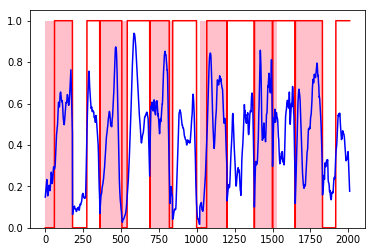

In [14]:
ground_truths, results = get_graph(result, ground_truth)

In [15]:
def get_auc(result, ground_truth):
    scores = []
    for video_idx in ground_truth:
        video_ground_truth = np.array(ground_truth[video_idx])
        video_result = np.array(result[video_idx])
        video_result = score_norm(video_result)
        video_result = score_smoothing(video_result)
        score = roc_auc_score(video_ground_truth, video_result)
        scores.append(score)
    return np.array(scores).mean()

In [16]:
auc = get_auc(result, ground_truth)

In [17]:
auc

0.9915315823615879

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(ground_truths, results)

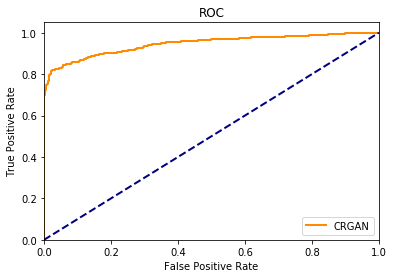

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='CRGAN')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()